In [29]:
library(tidyverse)
library(arcadiathemeR)

Loading Suisse fonts...



All custom fonts 'Suisse Int'l, Suisse Int'l Semi Bold, Suisse Int'l Medium, Suisse Int'l Mono' are successfully loaded.


In [2]:
setwd("..")

In [3]:
pos_ctrl_all <- read_tsv("sandbox/try_positive_controls_against_human_proteome/pos-control-vs-human-annotated.txt", show_col_types = FALSE) %>%
  mutate(accuracy = ifelse(target == correct_target, "correct", "incorrect"), .after = correct_target) %>%
  mutate(avg_tmscore = (alntmscore + ttmscore + qtmscore) / 3, .after = ttmscore) %>%
  rowwise() %>%
  mutate(min_tmscore = min(alntmscore, ttmscore, qtmscore), .after = avg_tmscore) %>%
  ungroup() 

pos_ctrl_correct <- pos_ctrl_all %>%
  filter(accuracy == "correct") 

In [4]:
# pull out constants that define minimum observations for positive controls
MIN_ALNLEN <- min(pos_ctrl_correct$alnlen)
MIN_TMSCORE <- min(pos_ctrl_correct$min_tmscore)
MAX_EVALUE <- max(pos_ctrl_correct$evalue)
MIN_LDDT <- min(pos_ctrl_correct$lddt)
MIN_QCOV <- min(pos_ctrl_correct$qcov)
MIN_TCOV <- min(pos_ctrl_correct$tcov)

In [36]:
MIN_ALNLEN
MIN_TMSCORE
MAX_EVALUE
MIN_LDDT
MIN_QCOV
MIN_TCOV

[1] 53

[1] 0.0394

[1] 0.0013

[1] 0.511

[1] 0.228

[1] 0.044

In [5]:
filter_foldseek_hits <- function(df) {
  df <- df %>%
    filter(alnlen >= MIN_ALNLEN) %>%
    filter(min_tmscore >= MIN_TMSCORE) %>%
    filter(evalue <= MAX_EVALUE) %>%
    filter(lddt >= MIN_LDDT) %>%
    filter(qcov >= MIN_QCOV) %>%
    filter(tcov >= MIN_TCOV)
  return(df)
}

## Test sorting by which variable puts the "correct" hit at the top

In [8]:
variables <- c("alnlen", "lddt", "alntmscore", "qtmscore", "ttmscore",
               "avg_tmscore", "min_tmscore", "evalue", "qcov", "tcov")

# Specify the sort order for each variable (desc for higher is better, asc for lower is better)
variable_sort_order <- c(
  "alnlen" = "desc",
  "lddt" = "desc",
  "alntmscore" = "desc",
  "qtmscore" = "desc",
  "ttmscore" = "desc",
  "avg_tmscore" = "desc",
  "min_tmscore" = "desc",
  "evalue" = "asc",  # Lower e-value is better
  "qcov" = "desc",
  "tcov" = "desc"
)

# Calculate the proportion of correct top hits for each variable
results <- lapply(variables, function(var) {
  df_sorted <- pos_ctrl_all %>%
    group_by(query)  # Replace 'query' with your actual query identifier column name
  if (variable_sort_order[[var]] == "desc") {
    df_sorted <- df_sorted %>% arrange(desc(.data[[var]]), .by_group = TRUE)
  } else {
    df_sorted <- df_sorted %>% arrange(.data[[var]], .by_group = TRUE)
  }
  df_top <- df_sorted %>% slice(1)
  proportion_correct <- mean(df_top$accuracy == "correct")
  tibble(variable = var, proportion_correct = proportion_correct)
})

# Combine the results into a single data frame
results_df <- bind_rows(results) %>%
  arrange(desc(proportion_correct))
results_df

variable,proportion_correct
<chr>,<dbl>
evalue,0.69230769
lddt,0.53846154
alntmscore,0.53846154
qtmscore,0.53846154
avg_tmscore,0.53846154
min_tmscore,0.46153846
ttmscore,0.38461538
qcov,0.23076923
tcov,0.15384615


## Filter positive controls to determine the number of top hits to keep

In [9]:
pos_ctrl_kept <- pos_ctrl_all %>%
  filter_foldseek_hits() %>%
  arrange(query, evalue) %>%
  group_by(query) %>%
  mutate(rank = row_number(), .after = accuracy)

In [25]:
pos_ctrl_correct_ranked <- pos_ctrl_kept %>%
  filter(accuracy == "correct")
# given this table, we would keep the top 8 hits to minimize throwing away true positives,
# and the top hit 

In [37]:
pos_ctrl_correct_ranked

query,target,correct_target,accuracy,rank,qlen,tlen,alnlen,alntmscore,qtmscore,⋯,evalue,cigar,qseq,tseq,qstart,qend,tstart,tend,qaln,taln
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
A0A4E9F9D5,Q6DKI2,Q6DKI2,correct,1,280,356,349,0.557,0.557,⋯,2.28e-27,30M1D8M3I19M1D18M1D60M72D12M1I30M1I32M2D40M1D17M,MANEYETNYPVPYRSKLTEPFEPGQTLLVKGKTAEDSVRFTINLHNTAADFSGSDVPLHISIRFDEGKIVFNTFSKGEWGKEERKSNPYKKGDDIDIRIRAHDSKYTIYVDQKEVKEYEHRVPLSSVTHFSIDGDVLVTYIHWGGKYYPVPYESGLSGEGLVPGKSLLIFATPEKKGKRFHINLLKKNGDIALHFNPRFDEKAIVRNSLIAGEWGNEEREGKMVLEKGIGFDLEIKNEEYAFQIFINSERYATYAHRVDPHEINGLQIGGDLEVSGIQMR,MAFSGCQAPYLSPAVPFSGTIQGGLQDGFQITVNGAVLSCSGTRFAVDFQTGFSGNDIAFHFNPRFEDGGYVVCNTRQKGTWGPEERKMHMPFQKGMPFDLCFLVQSSDFKVMVNGSLFVQYFHRVPFHRVDTISVNGSVQLSYISFQNPRAVPVQPAFSTVPFSQPVCFPPRPRGRRQKPPSVRPANPAPITQTVIHTVQSASGQMFSQTPAIPPMMYPHPAYPMPFITTIPGGLYPSKSIILSGTVLPSAQRFHINLCSGSHIAFHMNPRFDENAVVRNTQINNSWGSEERSLPRKMPFVRGQSFSVWILCEAHCLKVAVDGQHVFEYYHRLRNLPTINKLEVGGDIQLTHVQT,8,278,12,355,NYPVPYRSKLTEPFEPGQTLLVKGKTAEDS-VRFTINLHNTAADFSGSDVPLHISIRFDEG-KIVFNTFSKGEWGKEERK-SNPYKKGDDIDIRIRAHDSKYTIYVDQKEVKEYEHRVPLSSVTHFSIDGDVLVTYIHWGG------------------------------------------------------------------------KYYPVPYESGLSGEGLVPGKSLLIFATPEKKGKRFHINLLKKNGDIALHFNPRFDEKAIVRNSLIAGEWGNEEREG--KMVLEKGIGFDLEIKNEEYAFQIFINSERYATYAHRVDPH-EINGLQIGGDLEVSGIQ,SPAVPFSGTIQGGLQDGFQITVNGAVLSCSGTRFAVDFQ---TGFSGNDIAFHFNPRFEDGGYVVCNTRQKGTWGPEERKMHMPFQKGMPFDLCFLVQSSDFKVMVNGSLFVQYFHRVPFHRVDTISVNGSVQLSYISFQNPRAVPVQPAFSTVPFSQPVCFPPRPRGRRQKPPSVRPANPAPITQTVIHTVQSASGQMFSQTPAIPPMMYPHPAYPMPFITTIP-GGLYPSKSIILSGTVLPSAQRFHINLCSGS-HIAFHMNPRFDENAVVRNTQINNSWGSEERSLPRKMPFVRGQSFSVWILCEAHCLKVAVDGQHVFEYYHRLRNLPTINKLEVGGDIQLTHVQ
A0A504XZR6,P54577,P54577,correct,1,682,528,386,0.802,0.463,⋯,1.43e-18,30M1I18M1I30M4I2M3D9M4D28M2I77M1I13M1I2M1I32M7I5M8I21M5D2M1D43M1I24M1I9M,MNTDDRYKLLRSVGEECIQESELRNLIEKKPLIRCYDGFEPSGRMHIAQGIFKAVNVNKCTAAGCEFVFWVADWFALMNDKVGGELEKIRIVGRYLIEVWKAAGMDTDKVLFLWSSEEITSHADTYWRMVLDIGRQNTIARIKKCCTIMGKTEGTLTAAQVLYPLMQCCDIFFLKADICQLGLDQRKVNMLAREYCDLIGRKLKPVILSHHMLAGLRRGQAKMSKSDPDSAIFMEDTEEDVARKIRQAYCPRVKQSASAITDDGAPVATDDRNPVLDYFQCVVYARPGAVAAIDGTTYATYEDLEQAFVSDEVSEDALKSCLIDEVNALLAPVRQHFASNEEAHELLEAVKSYRKGGATLPLAETALPAAPEKPHACMWMPALLKVPLDVAEGMIKATEDFIAAHPGGTVTVVLPDWSAVASDEITGVEKDISAALQVNCALLKAYGLPNSVKIVTENEVILGNRNDFWVSVIGIARKNLLSHIEELYGGELRNAGQVIAALMRVATALMLSVSHVISTSLDGHINAFAREYTKERIECVQTLEGRIPALHRPGAAPAVLGADDVLYLDDNDMDIRRKIKKAYSAPNEEANPVISVAQHLLAQHGALNIERGEANGGNVSYNTPEALVADCGSGALHPADLKAAVLQLLLDRSAQARALLNGELKKNMTALRNAEKKMAKKR,MGDAPSPEEKLHLITRNLQEVLGEEKLKEILKERELKIYWGTATTGKPHVAYFVPMSKIADFLKAGCEVTILFADLHAYLDNMKAPWELLELRVSYYENVIKAMLESIGVPLEKLKFIKGTDYQLSKEYTLDVYRLSSVVTQHDSKKAGAEVVKQVEHPLLSGLLYPGLQALDEEYLKVDAQFGGIDQRKIFTFAEKYLPALGYSKRVHLMNPMVPGLTGSKMSSSEEESKIDLLDRKEDVKKKLKKAFCEPGNVENNGVLSFIKHVLFPLKSEFVILRDEKWGGNKTYTAYVDLEKDFAAEVVHPGDLKNSVEVALNKLLDPIREKFNTPALKKLASAAYPDPSKQKPMAKGPAKNSEPEEVIPSRLDIRVGKIITVEKHPDADSLYVEKIDVGEAEPRTVVSGLVQFVPKEELQDRLVVVLCNLKPQKMRGVESQGMLLCASIEGINRQVEPLDPPAGSAPGEHVFVKGYEKGQPDEELKPKKKVFEKLQADFKISEECIAQWKQTNFMTKLGSISCKSLKGGNIS,1,373,5,362,MNTDDRYKLLRSVGEECIQESELRNLIEKKPLIRCYDGFEPSGRMHIAQGIFKAVNVNKCTAAGCEFVFWVADWFALMNDKVGGEL---EKIRIVGRY----LIEVWKAAGMDTDKVLFLWSSEEITSHADTYWRMVLDIGRQNTIARIKKCCTIMGKTEGTLTAAQVLYPLMQCCDIFFLKADICQLGLDQRKVNMLAREYCDLIGRKLKPVILSHHMLAGLRRGQAKMSKSDPDSAIFMEDTEEDVARKIRQAYCPRVKQSASAITDDGAPVATDDRNPVLDYFQCVVYARPGAVAAI-----DG-TTYATYEDLEQAFVSDEVSEDALKSCLIDEVNALLAPVRQHFASNEEAHELLEAVKSYRKGGATLPLAETALPAAPEK,PSPEEKLHLITRNLQEVLGEEKLKEILKER-ELKIYWGTATTGKPHVAY-FVPMSKIADFLKAGCEVTILFADLHAYLDN----MKAPWELLELRVSYYENVIKAMLESIGVPLEKLKFIKGTDYQLSKE--YTLDVYRLSSVVTQHDSKKAGAEVVKQVEHPLLSGLLYPGLQALDEEYLKVDAQFGGIDQRKIFTFAEKYLPALGYS-KRVHLMNPMVPGL-TG-SKMSSSEEESKIDLLDRKEDVKKKLKKAFCEP-------GNVEN--------NGVLSFIKHVLFPLKSEFVILRDEKWGGNKTYTAYVDLEKDFAAEVVHPGDLKNSVEVALNKLLDPIREKFN-TPALKKLASAAYPDPSKQKPMAKG-PAKNSEPEE
APT70482.1,P35442,P35442,correct,8,219,1172,53,0.726,0.197,⋯,1.30e-03,25M3D3M1I4M1I16M,EKIKDEELCDLCDMADVILCRRKTSLCEVTQWSEWSGCSRPC

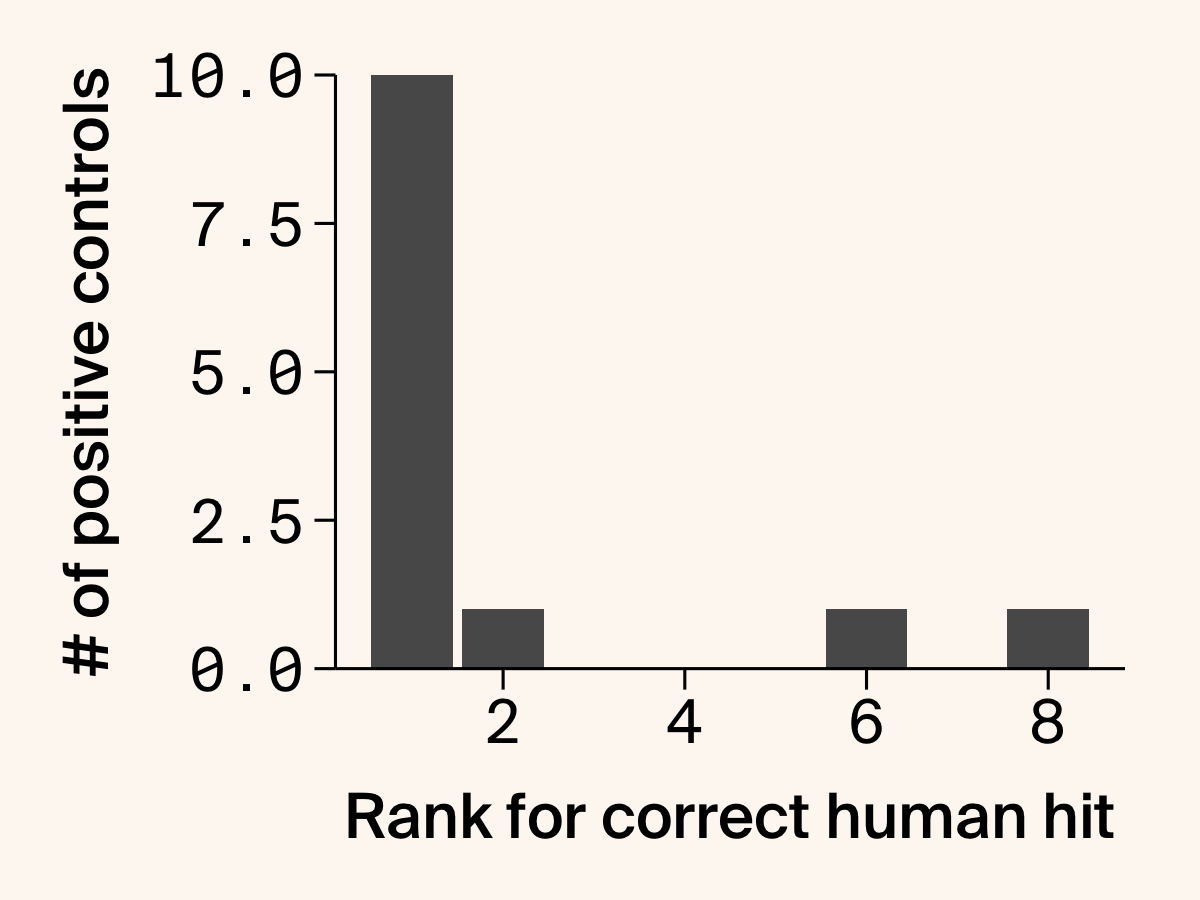

In [33]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 300)
ggplot(pos_ctrl_correct_ranked, aes(x = rank)) +
  geom_bar() +
  theme_arcadia() +
  clean_plot() +
  labs(x = "Rank for correct human hit",
       y = "# of positive controls")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


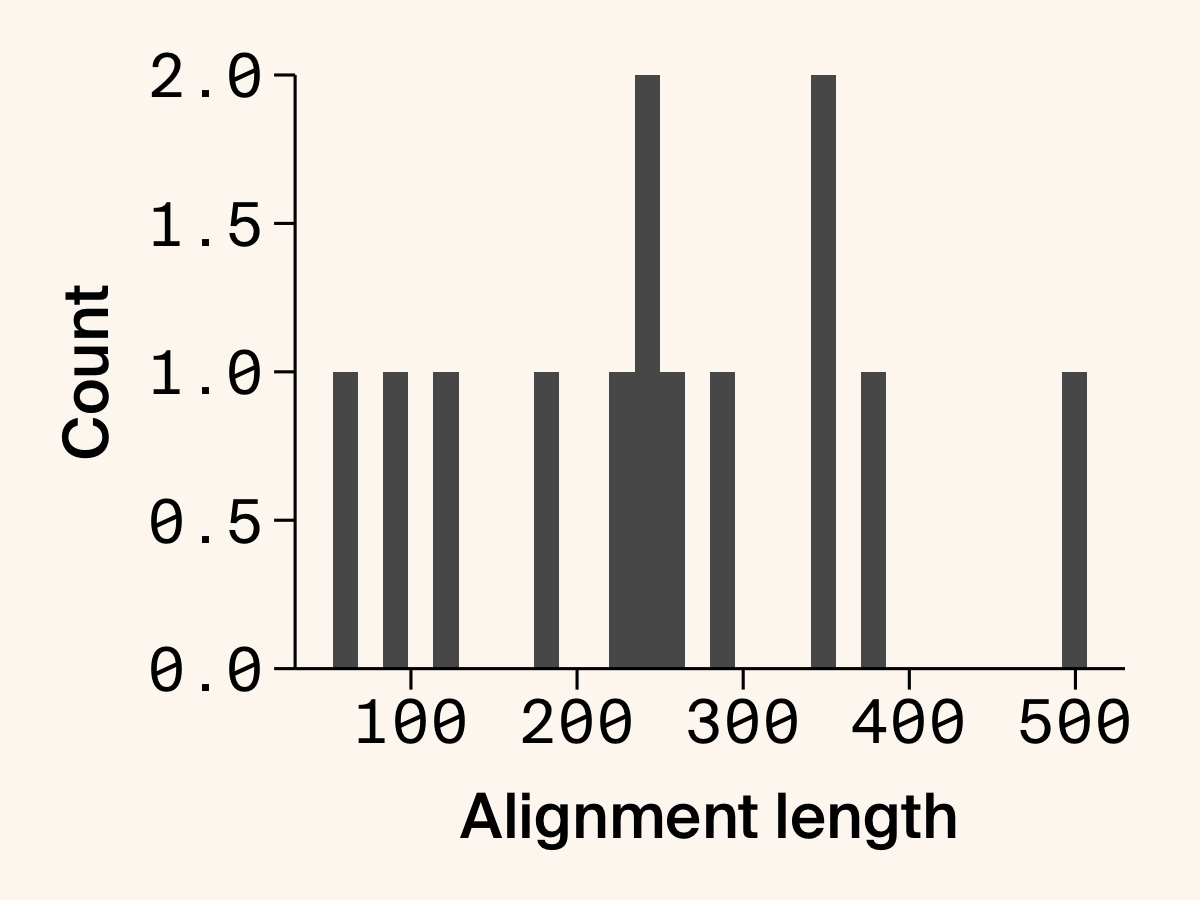

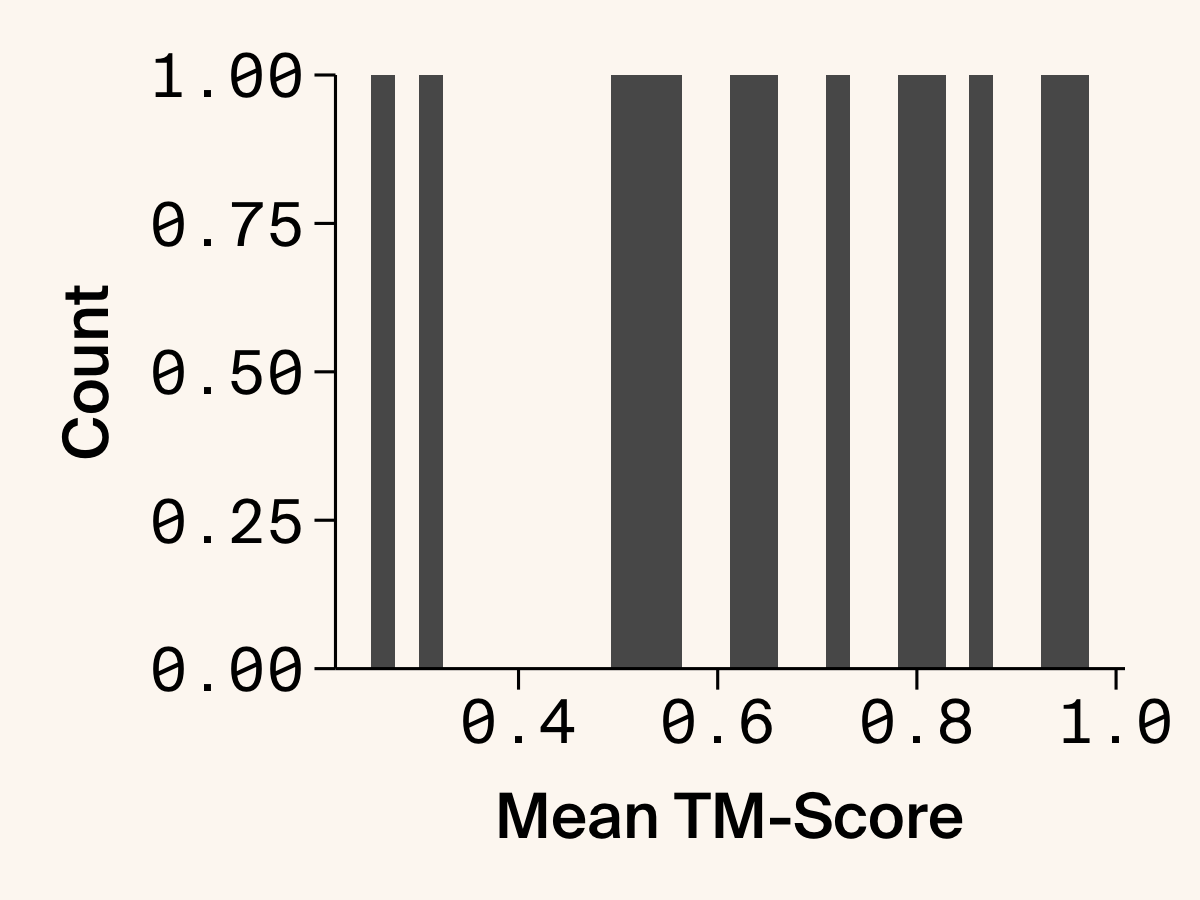

In [35]:
alnlen <- ggplot(pos_ctrl_correct, aes(x = alnlen)) +
  geom_histogram() +
  theme_arcadia() +
  clean_plot() +
  labs(x = "Alignment length")

tmscore <- ggplot(pos_ctrl_correct, aes(x = avg_tmscore)) +
  geom_histogram() +
  theme_arcadia() +
  clean_plot() +
  labs(x = "Mean TM-Score")

ggplot(pos_ctrl_correct, aes(x = avg_tmscore)) +
  geom_histogram() +
  theme_arcadia() +
  clean_plot() +
  labs(x = "Mean TM-Score")

## Read in virus results and then filter

In [16]:
viruses <- read_tsv("outputs/viruses/foldseek_with_uniprot_metadata/nomburg_human_viruses_with_uniprot_metadata.tsv.gz",
                    show_col_types = FALSE) %>%
  mutate(avg_tmscore = (alntmscore + ttmscore + qtmscore) / 3, .after = ttmscore) %>%
  rowwise() %>%
  mutate(min_tmscore = min(alntmscore, ttmscore, qtmscore), .after = avg_tmscore) %>%
  ungroup() 

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


In [17]:
nrow(viruses)

[1] 55624

In [18]:
viruses %>% group_by(query) %>% tally() %>% ungroup() %>% summarise(mean_n = mean(n))

mean_n
<dbl>
64.98131


In [19]:
viruses_filtered <- viruses %>%
  filter_foldseek_hits()

In [21]:
nrow(viruses_filtered)

[1] 18300

In [23]:
viruses_filtered2 <- viruses_filtered %>%
  arrange(query, evalue) %>%
  group_by(query) %>%
  mutate(rank = row_number(), .after = min_tmscore) %>%
  filter(rank <= 8)

nrow(viruses_filtered2)

[1] 2272

In [24]:
viruses_filtered2 <- viruses_filtered %>%
  arrange(query, evalue) %>%
  group_by(query) %>%
  mutate(rank = row_number(), .after = min_tmscore) %>%
  filter(rank == 1)

nrow(viruses_filtered2)

[1] 437

## Read in euk results and then filter

In [38]:
eukaryotes <- read_tsv("outputs/structural_comparison/foldseek_with_uniprot_metadata/20241018_combined_with_uniprot_metadata.tsv.gz",
                    show_col_types = FALSE) %>%
  mutate(avg_tmscore = (alntmscore + ttmscore + qtmscore) / 3, .after = ttmscore) %>%
  rowwise() %>%
  mutate(min_tmscore = min(alntmscore, ttmscore, qtmscore), .after = avg_tmscore) %>%
  ungroup() 

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”


In [39]:
nrow(eukaryotes)

[1] 730665

In [40]:
eukaryotes %>% group_by(query) %>% tally() %>% ungroup() %>% summarise(mean_n = mean(n))

mean_n
<dbl>
45.21162


In [41]:
eukaryotes_filtered <- eukaryotes %>%
  filter_foldseek_hits()

In [42]:
nrow(eukaryotes_filtered)

[1] 277119

In [43]:
eukaryotes_filtered2 <- eukaryotes_filtered %>%
  arrange(query, evalue) %>%
  group_by(query) %>%
  mutate(rank = row_number(), .after = min_tmscore) %>%
  filter(rank <= 8)

nrow(eukaryotes_filtered2)

[1] 64912

In [44]:
eukaryotes_filtered2 <- eukaryotes_filtered %>%
  arrange(query, evalue) %>%
  group_by(query) %>%
  mutate(rank = row_number(), .after = min_tmscore) %>%
  filter(rank <= 1)

nrow(eukaryotes_filtered2)

[1] 12616

In [45]:
write_tsv(eukaryotes_filtered2, "outputs/structural_comparison/foldseek_with_uniprot_metadata/20241018_combined_with_uniprot_metadata_filtered.tsv.gz")

In [46]:
write_tsv(viruses_filtered2, "outputs/viruses/foldseek_with_uniprot_metadata/20241018_nomburg_human_viruses_with_uniprot_metadata_filtered.tsv")